<a href="https://colab.research.google.com/github/AmrMKayid/FaceGAN/blob/master/FaceGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title #**Install the required components** { display-mode: "form" }
%%time
%tensorflow_version 1.x
!pip install tensorflow-gpu==1.14

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
import math
import pickle
import imageio
import PIL.Image
import numpy as np
from PIL import Image
import tensorflow as tf
import moviepy.editor as mpy
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import clear_output
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

clear_output()
import tensorflow as tf
print(tf.__version__)

1.15.2
CPU times: user 2.13 s, sys: 517 ms, total: 2.65 s
Wall time: 1min 21s


In [2]:
#@title #**Cloning FaceGAN** { display-mode: "form" }
%%bash
rm -rf /content/* /content/.git* 2> /dev/null 
git clone https://github.com/AmrMKayid/facegan.git /tmp/facegan
mv /tmp/facegan/* /tmp/facegan/.git* . 
rm -rf /tmp/facegan

Cloning into '/tmp/facegan'...


Image captured and saved to /content/facegan/data/raw/photo_21-Aug-2020_15:06:06.png
Image /content/facegan/data/raw/photo_21-Aug-2020_15:06:06.png is saved! with shape (600, 800, 3)


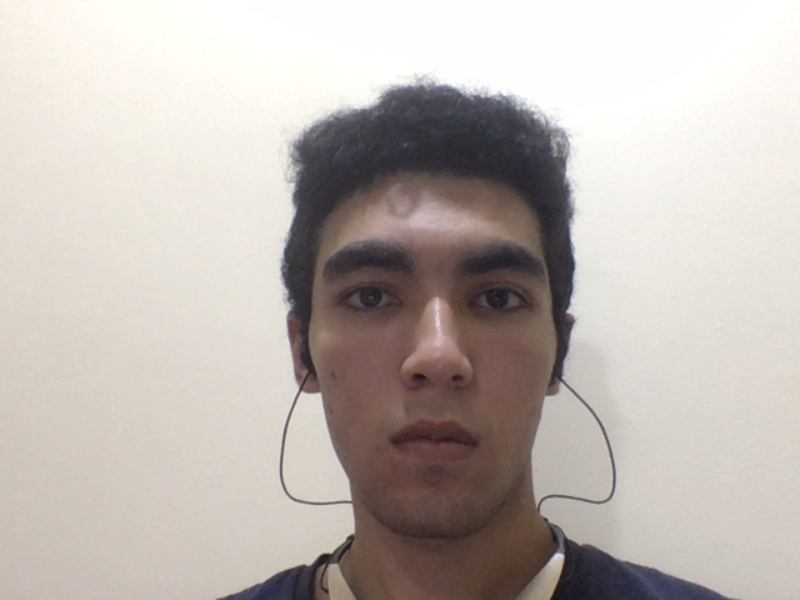

In [20]:
#@title #**Add/Upload a photo with a face** { display-mode: "form" }

#@markdown ### You can choose between taking a photo through **WebCam**, **Upload** a photo from your device, or past a **URL** to get a photo.

from facegan import ROOT_PATH
import facegan.utils.utils as utils

method = 'webcam' #@param ["webcam", "url", "upload"]

if method == 'webcam':
  image, fn = utils.take_photo()
elif method == 'url':
  try:
    #@markdown ---
    url = 'https://raw.githubusercontent.com/AmrMKayid/FaceGAN/master/facegan/data/raw/test.jpg' #@param {type:"string"}
    !wget $url
    fp = url.split('/')[-1]
  except BaseException:
    print("Something went wrong. Try uploading photos from your computer")
else:
  image = files.upload()
  for fp in image.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fp, length=len(image[fp])))
    
if method != 'webcam':
  os.rename(fp, fp.replace(" ", ""))
  fp = fp.replace(" ", "")
  fn = 'photo.'+ fp.split('.')[-1]
  !mv $fp /content/facegan/data/raw/$fn
  clear_output()
  print("Photo Saved\n")

  image = PIL.Image.open('/content/facegan/data/raw/' + fn)
  wpercent = (512/float(image.size[0]))
  hsize = int((float(image.size[1])*float(wpercent)))
  image = image.resize((512,hsize), PIL.Image.LANCZOS)

print(f"Image {fn} is saved! with shape {np.array(image).shape}")
display(image)

In [ ]:
#@markdown ---
#@markdown ---
#@markdown ---

In [25]:
#@title #**Multiface Detection** { display-mode: "form" }

!rm -rf $ROOT_PATH/data/cropped/*
#@markdown ### Running this cell if there is more than one face in the image

multiface = False #@param {type:"boolean"}

if multiface:
  from facegan.process.multifaces import MultiFaceCropper

  mfc = MultiFaceCropper()
  image = mfc.crop(np.array(image))
  print(image)
  display(Image.fromarray(image[0]).resize((256,256), PIL.Image.LANCZOS))

In [ ]:
#@markdown ---
#@markdown ---
#@markdown ---

64045056/64040097 [==============================] - 3s 0us/step
Aligning photo_21-Aug-2020_15:06:06.png ...
Starting face alignment...
<PIL.Image.Image image mode=RGB size=800x600 at 0x7FE7BE127400>
Wrote result /content/facegan/data/aligned/photo_21-Aug-2020_15:06:06.png


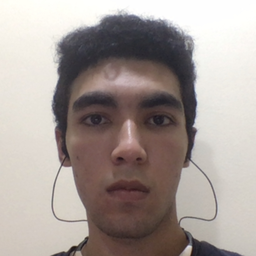

In [26]:
#@title #**Face Alignment** { display-mode: "form" }

#@markdown ### Aligning the face to match the model dataset
from facegan.process.align_images import FaceAligner

face_aligner = FaceAligner()
if multiface:
  images = face_aligner.auto_align()
else:
  images = face_aligner.auto_align(raw_dir=f'{ROOT_PATH}/data/raw')

for image in images:
  image = image.resize((256,256), PIL.Image.LANCZOS)
  display(image)

In [ ]:
#@markdown ---
#@markdown ---
#@markdown ---

In [40]:
#@title #**StyleGAN Encoding** { display-mode: "form" }
%%time
!rm -rf $ROOT_PATH/data/latent_representations/ $ROOT_PATH/data/generated_images/
#@markdown ### Encoding the aligned images into the latent space of StyleGANs
#@markdown <br> 

#@markdown ---
#@markdown ---
#@markdown **Choose an image encoding method:**

#@markdown *Slow method works 2 times longer, but has much higher quality.*
metod = 'Fast (low quality)' #@param ["Fast (low quality)", "Slow (high quality)"]
#@markdown ---

#@markdown **Select a network that matches the type of face in the input image.:**
network = 'asian beauty' #@param ["default", "european", "asian", "asian beauty", "baby"]
#@markdown ---
from facegan.utils import nets
network_path = nets.download_networks(network)

#@markdown **Set the number of iterations of network learning:**

#@markdown *Recommended: 700*
iterat = 700 #@param {type:"slider", min:100, max:1500, step:50}
#@markdown ---

#@markdown **Set learning rate:**

#@markdown *Recommended: 0.1*
learning_rate = 0.1 #@param {type:"slider", min:0.001, max:1, step:0.001}
#@markdown ---

#@markdown **Delete logs after executing this block:**
delete_logs = True #@param {type:"boolean"}
#@markdown ---

Downloading...
From: https://drive.google.com/uc?id=1-04v78_pI59M0IvhcKxsm3YhK2-plnbj
To: /content/generator_star-stylegan2-config-f.pkl
382MB [00:04, 87.3MB/s]


CPU times: user 603 ms, sys: 993 ms, total: 1.6 s
Wall time: 8.04 s


In [33]:
!du -sh /content/facegan/data/models/

521M	/content/facegan/data/models/


In [37]:
network_path

'/content/facegan/data/models/generator_yellow-stylegan2-config-f.pkl'

In [ ]:
#@markdown ---
#@markdown ---
#@markdown ---

# StyleGAN Exp

In [ ]:
#@title `Encoding faces into StyleGAN Latent Space`
print('Download a pretrained resnet encoder...')
# model takes an image as input and estimates the corresponding latent code
!gdown https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
!mkdir data
!mv finetuned_resnet.h5 data
!rm -rf generated_images latent_representations

In [ ]:
print("aligned_images contains %d images ready for encoding!" %len(os.listdir('aligned_images/')))
print("Recommended batch_size for the encode_images process: %d" %min(len(os.listdir('aligned_images/')), 8))

In [ ]:
FAST=True

if FAST:
  print("\n************ Start FAST Latent code optimization process ***************")
  !python encode_images.py --optimizer=lbfgs --face_mask=True --iterations=6 --use_lpips_loss=0 --use_discriminator_loss=0 --output_video=True aligned_images/ generated_images/ latent_representations/
else:
  print("\n************ Start SLOW Latent code optimization process ***************")
  !python encode_images.py --optimizer=adam --lr=0.02 --decay_rate=0.95 --decay_steps=6 --use_l1_penalty=0.3 --face_mask=True --iterations=400 --early_stopping=True --early_stopping_threshold=0.05 --average_best_loss=0.5 --use_lpips_loss=0 --use_discriminator_loss=0 --output_video=True aligned_images/ generated_images/ latent_representations/

print("\n************ Latent code optimization finished! ***************")

In [ ]:
#@title `loading StyleGAN network into memory`

import dnnlib, pickle
import dnnlib.tflib as tflib
tflib.init_tf()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)

model_dir = 'cache/'
model_path = [model_dir+f for f in os.listdir(model_dir) if 'stylegan-ffhq' in f][0]
print("Loading StyleGAN model from %s..." %model_path)

with dnnlib.util.open_url(model_path) as f:
  generator_network, discriminator_network, averaged_generator_network = pickle.load(f)
  
print("StyleGAN loaded & ready for sampling!")

In [ ]:
#@title `images viz utils`

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def generate_images(generator, latent_vector, z = True):
    batch_size = latent_vector.shape[0]
    
    if z: #Start from z: run the full generator network
        return generator.run(latent_vector.reshape((batch_size, 512)), None, randomize_noise=False, **synthesis_kwargs)
    else: #Start from w: skip the mapping network
        return generator.components.synthesis.run(latent_vector.reshape((batch_size, 18, 512)), randomize_noise=False, **synthesis_kwargs)

def plot_imgs(model, rows, columns):
  for i in range(rows):
    f, axarr = plt.subplots(1,columns, figsize = (20,8))
    for j in range(columns):
      img = generate_images(model, np.random.randn(1,512), z = True)[0]
      axarr[j].imshow(img)
      axarr[j].axis('off')
      axarr[j].set_title('Resolution: %s' %str(img.shape))
    plt.show()

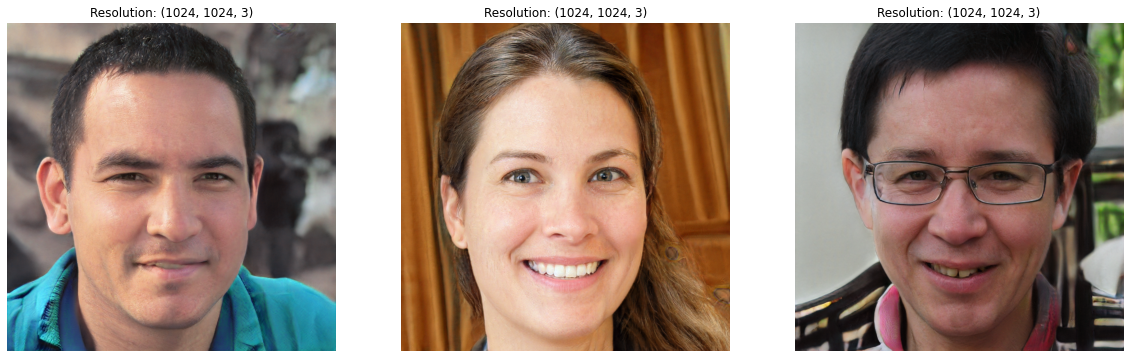

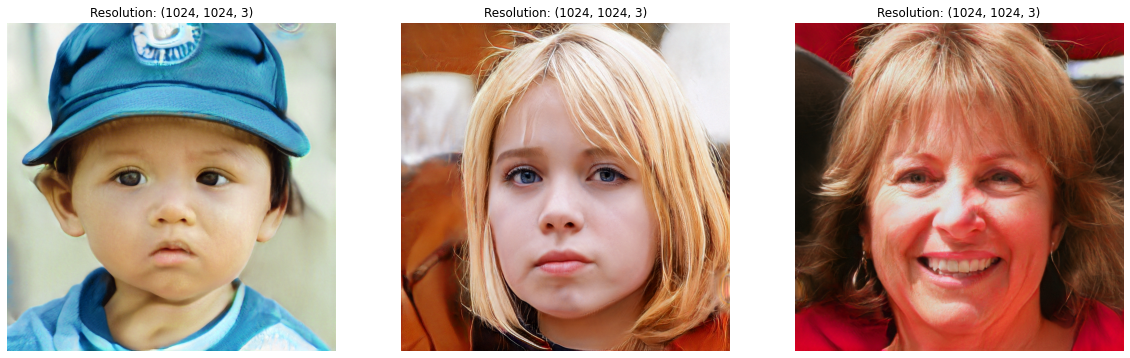

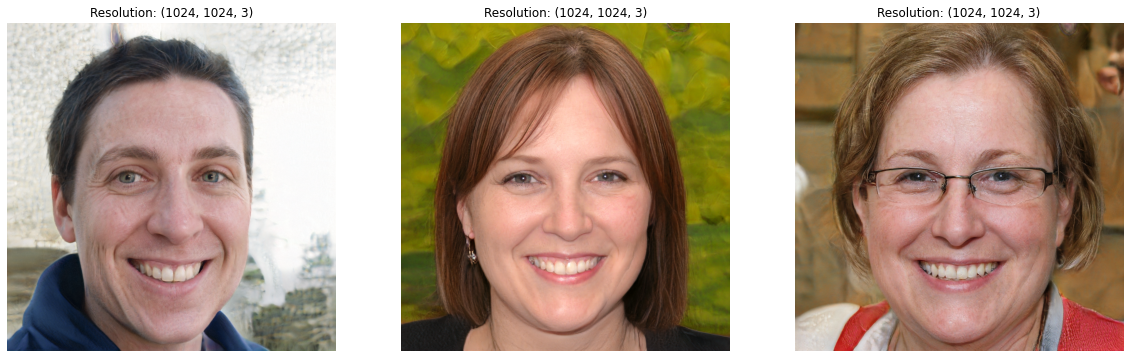

In [ ]:
#@title `Plotting random StyleGAN Samples`
plot_imgs(averaged_generator_network, 3, 3)

In [ ]:
#@title `Results of Encoding`

for f in sorted(os.listdir('latent_representations')):
  w = np.load('latent_representations/' + f).reshape((1,18,-1))
  img = generate_images(averaged_generator_network, w, z = False)[0]
  plt.imshow(img)
  plt.axis('off')
  plt.title("Generated image from %s" %f)
  plt.show()

In [ ]:
#@title `Compare encoded samples with the original ones`

def plot_two_images(img1,img2, img_id, fs = 12):
  f, axarr = plt.subplots(1,2, figsize=(fs,fs))
  axarr[0].imshow(img1)
  axarr[0].title.set_text('Encoded img %d' %img_id)
  axarr[1].imshow(img2)
  axarr[1].title.set_text('Original img %d' %img_id)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

def display_sbs(folder1, folder2, res = 256):
  if folder1[-1] != '/': folder1 += '/'
  if folder2[-1] != '/': folder2 += '/'
    
  imgs1 = sorted([f for f in os.listdir(folder1) if '.png' in f])
  imgs2 = sorted([f for f in os.listdir(folder2) if '.png' in f])
  if len(imgs1)!=len(imgs2):
    print("Found different amount of images in aligned vs raw image directories. That's not supposed to happen...")
  
  for i in range(len(imgs1)):
    img1 = Image.open(folder1+imgs1[i]).resize((res,res))
    img2 = Image.open(folder2+imgs2[i]).resize((res,res))
    plot_two_images(img1,img2, i)
    print("")
     
display_sbs('generated_images/', 'aligned_images/', res = 512)

In [ ]:
#@title `Cherry pick images & dump latent vectors to disk`

good_images = [i for i in range(2)] # encoded images numbers

latents = sorted(os.listdir('latent_representations'))

out_file = '/content/output_vectors.npy'

final_w_vectors = []
for img_id in good_images:
  w = np.load('latent_representations/' + latents[img_id])
  final_w_vectors.append(w)

final_w_vectors = np.array(final_w_vectors)
np.save(out_file, final_w_vectors)
print("%d latent vectors of shape %s saved to %s!" %(len(good_images), str(w.shape), out_file))

2 latent vectors of shape (18, 512) saved to /content/output_vectors.npy!


# Manipulating the faces

In [ ]:
#@title `Cloning InterFaceGAN`
%cd /content/
!git clone https://github.com/ShenYujun/InterFaceGAN
%cd InterFaceGAN

/content
Cloning into 'InterFaceGAN'...
remote: Enumerating objects: 223, done.
remote: Total 223 (delta 0), reused 0 (delta 0), pack-reused 223
Receiving objects: 100% (223/223), 11.38 MiB | 24.96 MiB/s, done.
Resolving deltas: 100% (70/70), done.
/content/InterFaceGAN


In [ ]:
#@title `Download the pretrained StyleGAN FFHQ network from NVIDIA`
!gdown https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ
!mv karras2019stylegan-ffhq-1024x1024.pkl /content/InterFaceGAN/models/pretrain/karras2019stylegan-ffhq-1024x1024.pkl

Downloading...
From: https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ
To: /content/InterFaceGAN/karras2019stylegan-ffhq-1024x1024.pkl
325MB [00:02, 151MB/s]


In [ ]:
#@title `Load Our custom latent space vectors`

final_w_vectors = np.load('/content/output_vectors.npy')

print("%d latent vectors of shape %s loaded from %s!" %(final_w_vectors.shape[0], str(final_w_vectors.shape[1:]), 'output_vectors.npy'))

2 latent vectors of shape (18, 512) loaded from output_vectors.npy!


In [ ]:
#@title `Boundaries`

# Some Attr Boundaries (-b argument)
# Boundaries: https://github.com/ShenYujun/InterFaceGAN/tree/master/boundaries

# stylegan_ffhq_age_w_boundary.npy
# stylegan_ffhq_eyeglasses_w_boundary.npy
# stylegan_ffhq_gender_w_boundary.npy
# stylegan_ffhq_pose_w_boundary.npy
# stylegan_ffhq_smile_w_boundary.npy

In [ ]:
#@title `Latent Space Configs`

latent_direction = 'age'      #@param ['age', 'eyeglasses', 'gender', 'pose', 'smile'] {allow-input: true}

# Controls how strongly we push the face into a certain latent direction (try 1-5)
morph_strength = 3           #@param {type:"slider", min:0, max:5, step:1} 

# The amount of intermediate steps/frames to render along the interpolation path
nr_interpolation_steps = 48  #@param {type:"slider", min:0, max:100, step:1} 

In [ ]:
boundary_file = 'stylegan_ffhq_%s_w_boundary.npy' %latent_direction

print("Ready to start manipulating faces in the ** %s ** direction!" %latent_direction)
print("Interpolation from %d to %d with %d intermediate frames." %(-morph_strength, morph_strength, nr_interpolation_steps))
print("\nLoading latent directions from %s" %boundary_file)

Ready to start manipulating faces in the ** age ** direction!
Interpolation from -3 to 3 with 48 intermediate frames.

Loading latent directions from stylegan_ffhq_age_w_boundary.npy


In [ ]:
#@title `Running latent interpolations`
import subprocess
return_code = subprocess.call("rm -r results/%s" %latent_direction, shell=True)

run_command = "python edit.py \
      -m stylegan_ffhq \
      -b boundaries/stylegan_ffhq_%s_w_boundary.npy \
      -s Wp \
      -i '/content/output_vectors.npy' \
      -o results/%s \
      --start_distance %.2f \
      --end_distance %.2f \
      --steps=%d" %(latent_direction, latent_direction, -morph_strength, morph_strength, nr_interpolation_steps)


print("Running latent interpolations... This should not take longer than ~1 minute")
print("Running: %s" %run_command)
return_code = subprocess.call(run_command, shell=True)

if not return_code:
  print("Latent interpolation successfully dumped to disk!")
else:
  print("Something went wrong, try re-executing this cell...")

Running latent interpolations... This should not take longer than ~1 minute
Running: python edit.py       -m stylegan_ffhq       -b boundaries/stylegan_ffhq_age_w_boundary.npy       -s Wp       -i '/content/output_vectors.npy'       -o results/age       --start_distance -3.00       --end_distance 3.00       --steps=48
Something went wrong, try re-executing this cell...


In [ ]:
#@title `Results into movies`

image_folder = '/content/InterFaceGAN/results/%s' %latent_direction
video_fps = 12.

from moviepy.editor import *
import cv2

out_path = '/content/output_videos/'

images = [img_path for img_path in sorted(os.listdir(image_folder)) if '.jpg' in img_path]
os.makedirs(out_path, exist_ok=True)

prev_id = None
img_sets = []
for img_path in images:
  img_id = img_path.split('_')[0]
  if img_id == prev_id: #append
    img_sets[-1].append(img_path)
    
  else: #start a new img set
    img_sets.append([])
    img_sets[-1].append(img_path)
  prev_id = img_id

print("Found %d image sets!\n" %len(img_sets))
if image_folder[-1] != '/':
  image_folder += '/'

def make_video(images, vid_name):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(vid_name, fourcc, video_fps, (1024, 1024))
    gen = {}
    for img in images:
      video.write(img)
    video.release()
    print('finished '+ vid_name)
    
    
for i in range(len(img_sets)):
  print("############################")
  print("\nGenerating video %d..." %i)
  set_images = []
  vid_name = out_path + 'out_video_%s_%02d.mp4' %(latent_direction,i)
  for img_path in img_sets[i]:
    set_images.append(cv2.imread(image_folder + img_path))

  set_images.extend(reversed(set_images))
  make_video(set_images, vid_name)

In [ ]:
#@title `Visualise resulting videos inside Notebook`

video_file_to_show = 0 #@param {type:"slider", min:0, max:5, step:1} 

clip = VideoFileClip(
    '/content/output_videos/out_video_%s_%02d.mp4' %
    (latent_direction, video_file_to_show),)
clip.ipython_display(
    height=512,
    autoplay=1,
    loop=1,
)